In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import cv2
import pandas as pd
from skimage import *

import tensorflow as tf
import keras 
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model, multi_gpu_model
# from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import losses

from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

In [3]:
pwd

'/home/dgxadmin/gcubme4/Workspace/JW_Seo/DVT_detection/Radiomics/code/deep_learning'

In [4]:
def base_block(inputs, filters = 4, scale = 2):
    
#     x = Conv2D(filters, 3, strides= 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
   
    x = Conv2D(filters, 3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    base_out = Activation(activation='relu')(x)

    
    return base_out

def bottleneck(inputs, filters):

    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 3, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(filters, 1, activation=None, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)

    return x

def residual_block(inputs, filters):
    
    shortcut = inputs
#     print('input')
#     print('shortcut:',shortcut.shape)
#     print('x:',inputs.shape)
    
    x = Conv2D(filters, kernel_size=3, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    
    x = bottleneck(x, filters)
    
    shortcut = Conv2D(filters, kernel_size=1, strides=1, activation=None, padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)
#     print('before add')
#     print('shortcut:',shortcut.shape)
#     print('x:',x.shape)
    x = add([x, shortcut])
    
    res_out = Activation(activation='relu')(x)
    
    return res_out

def base_classification_jw(inputs, filters = 4, scale = 2):
    
    layer=2
    for br in range(layer):
        
        if br == 0:
#             print(br)
            conv= base_block(inputs)
            
            conv = MaxPooling2D(pool_size=(3, 3), strides = 2)(conv)
            print(conv.shape)
            
        else:
#             print(br)
#             print(conv.shape, scale, br, filters)
            num = (scale**br) *  filters
            conv= residual_block(conv, filters= num)
#             print(conv.shape)
#             print(num)
    
            conv= MaxPooling2D(pool_size=(2, 2), strides = 2)(conv)
#             print(conv.shape)
    for ar in range(layer):
#         print(num)
        num = int(num/scale)
        conv = base_block(conv, filters = num)
#         print(num)    
        
            
    out= Flatten()(conv)
  
    out = Dense(1, activation="sigmoid")(out)
    
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model           

In [5]:
from keras.models import Sequential

input_img = Input(shape=(32,32,1))
model = base_classification_jw(input_img, filters = 4, scale = 2)
model.summary()

(None, 15, 15, 4)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 4)    16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 4)    0           batch_normalization_1[0][0]      
__________________________________________________________________________

In [3]:
help(np.ndarray)

Help on class ndarray in module numpy:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |

In [6]:
print("loading data")

abnormal = np.load('../DVT_detection/Radiomics/data/npy/abnormal_16to32.npy')
normal = np.load('../DVT_detection/Radiomics/data/npy/normal_16to32.npy')

all_len= abnormal.shape[0]+ normal.shape[0]
test_len = int((all_len)/5)
train_len = all_len - test_len

print('all_len:{}, train_len:{}, test_len:{}'.format(all_len,train_len, test_len))
img_train=np.ndarray((train_len,32,32,1), dtype=np.uint8)
img_test=np.ndarray((test_len,32,32,1), dtype=np.uint8)
lab_train=np.ndarray((train_len,1), dtype=np.uint8)
lab_test=np.ndarray((test_len,1), dtype=np.uint8)
for sp in range(0,int(all_len/2)):
    if sp<train_len/2:
        img_train[sp][:,:,:]=normal[sp][:,:,:]
        lab_train[sp]=0
        img_train[sp+int(train_len/2)][:,:,:]=abnormal[sp][:,:,:]
        lab_train[sp+int(train_len/2)]=1
        
    else:

        img_test[sp-int(train_len/2)][:,:,:]=normal[sp][:,:,:]
        lab_test[sp-int(train_len/2)]=0
        img_test[sp-int(train_len/2)+int(test_len/2)][:,:,:]=abnormal[sp][:,:,:]
        lab_test[sp-int(train_len/2)+int(test_len/2)]=1
        
# img_test = np.load('../test_img_32_bilinear.npy')
# lab_train= np.load('../train_label_32_bilinear.npy')
# lab_test= np. load('../test_label_32_bilinear.npy')


print("loading data done")
print(img_train.shape)
print(img_test.shape)
print(lab_train.shape)
print(lab_test.shape)

loading data
all_len:1624, train_len:1300, test_len:324
loading data done
(1300, 32, 32, 1)
(324, 32, 32, 1)
(1300, 1)
(324, 1)


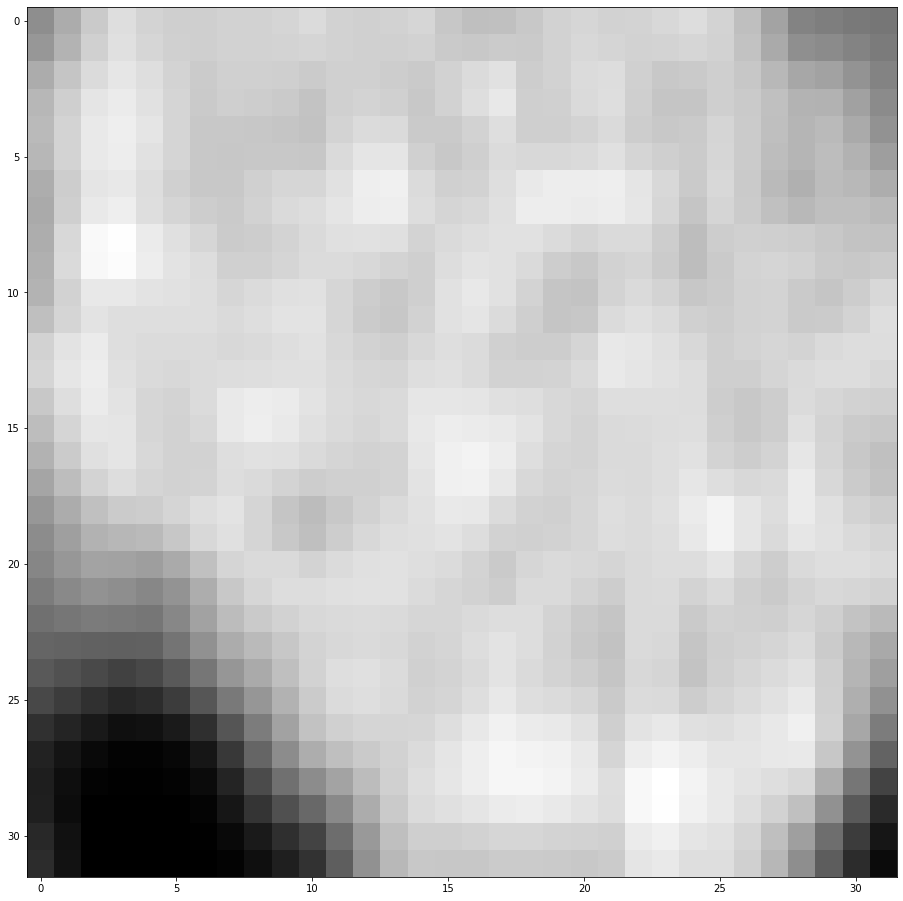

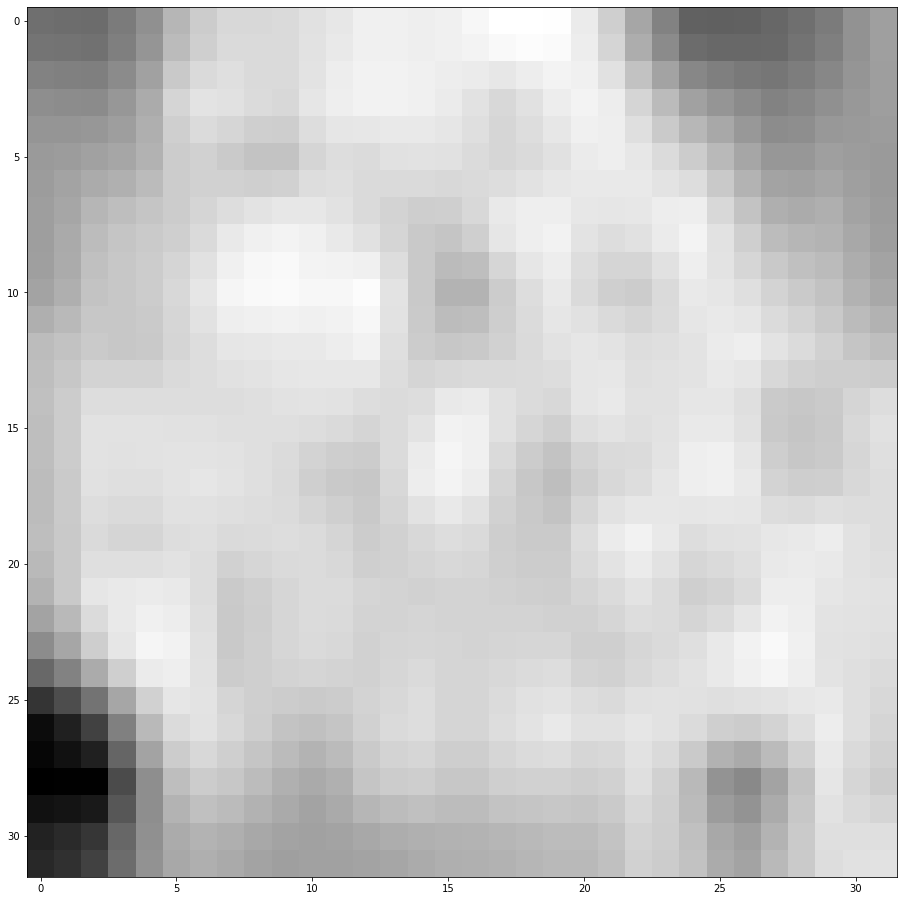

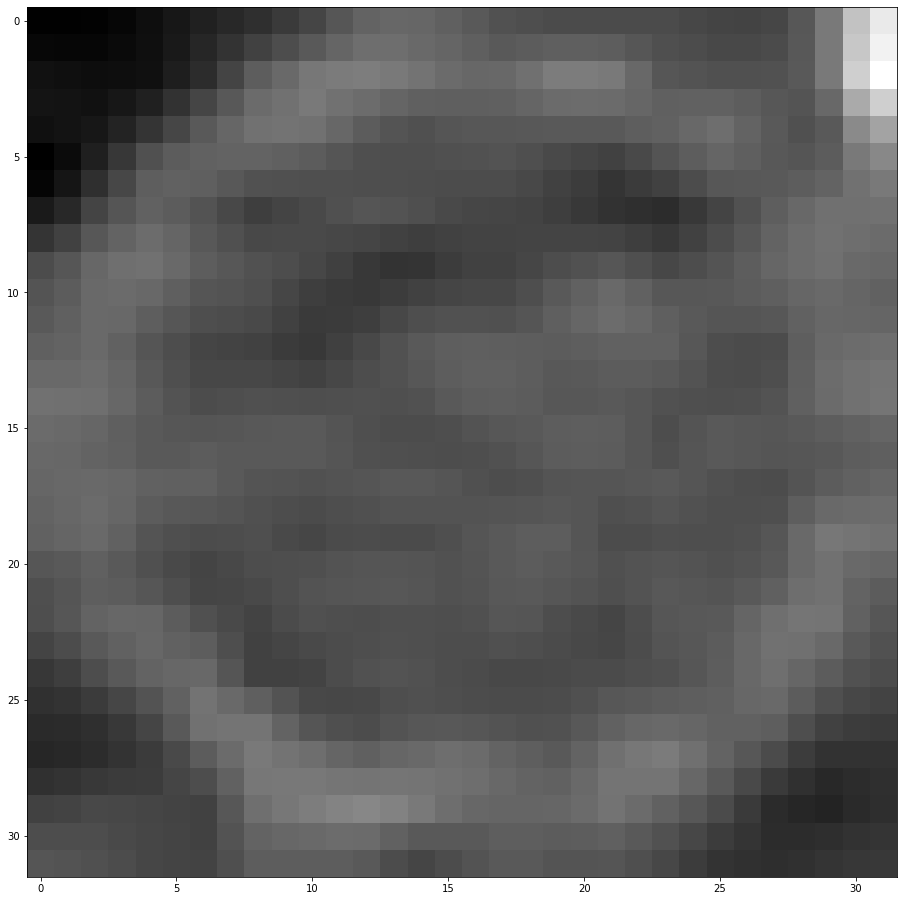

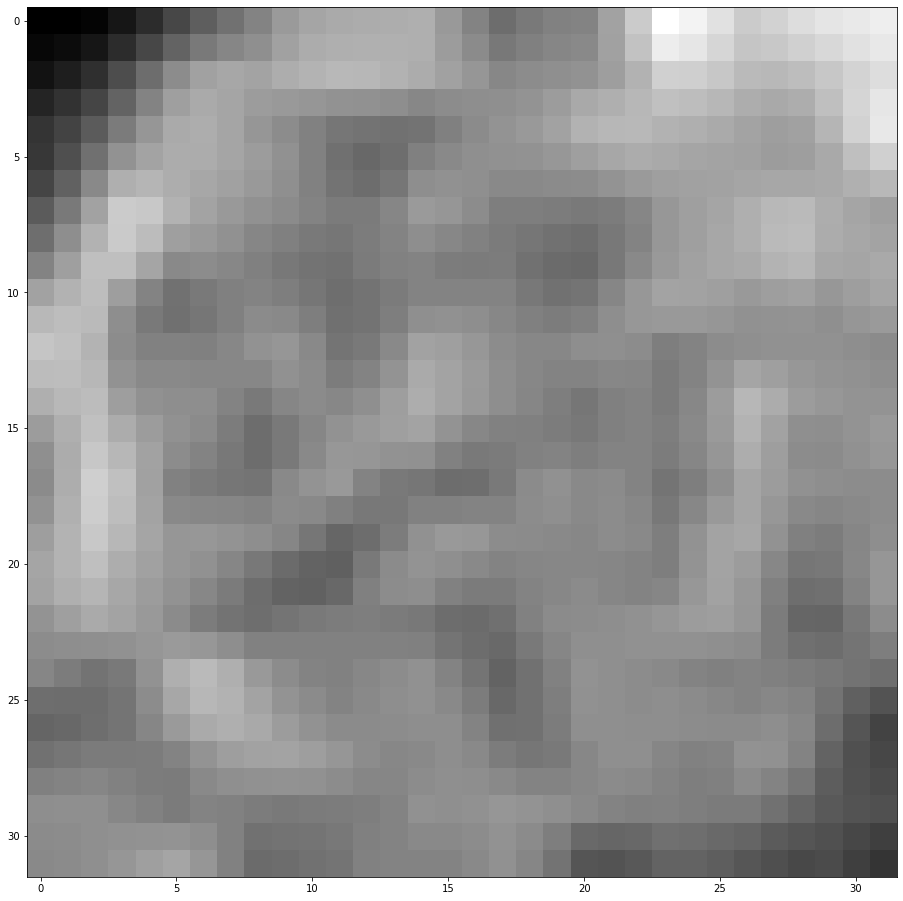

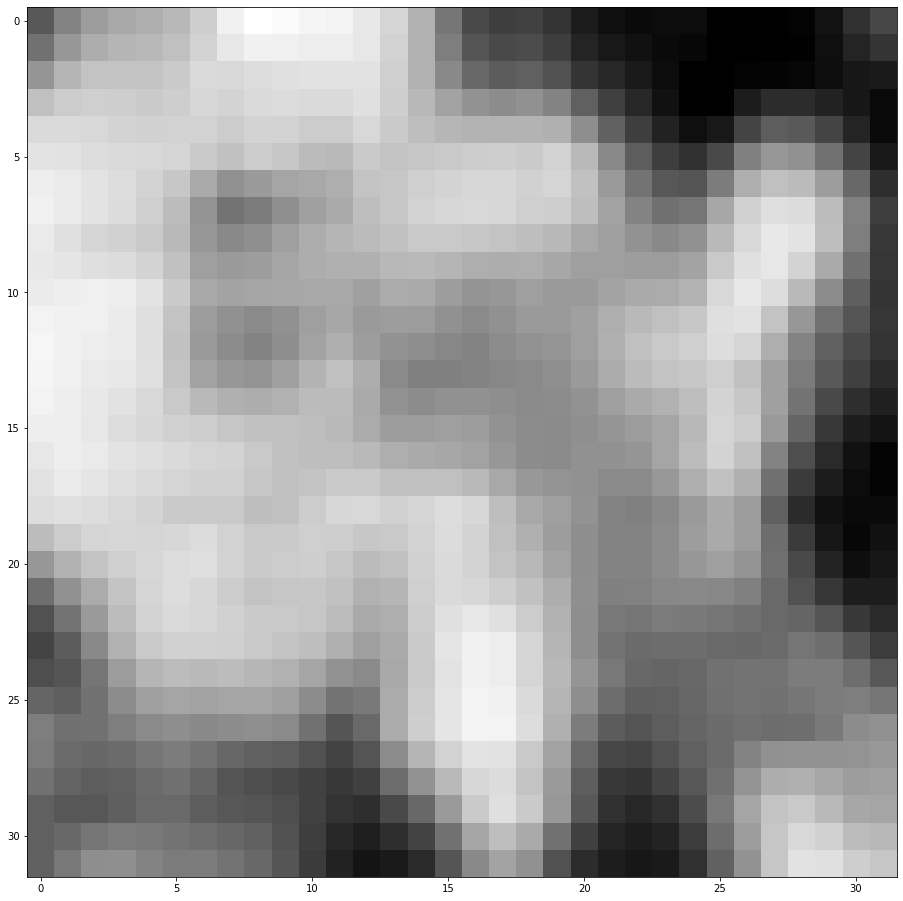

In [15]:
train_checkList=[0,int(train_len/2)-1,int(train_len/2),int(train_len/2)+1, len(img_train)-1]
test_checkList=[0,int(test_len/2)-1,int(test_len/2),int(test_len/2)+1, len(img_test)-1]
for a in test_checkList:
    plt.figure(figsize=(16,16))
#     plt.subplot(1,2,1)
#     plt.imshow(img_train[a,:,:,0], cmap='gray')
#     plt.subplot(1,2,2)
    plt.imshow(img_test[a,:,:,0], cmap='gray')

In [16]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./210303/residual_filter4_0303.h5', verbose=1, save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0, min_delta=0.001, verbose=1)
earlystopper = EarlyStopping(patience=30, verbose=1, monitor='loss')
callbacks_list = [reduce_lr, checkpointer, earlystopper]


In [17]:
results = model.fit(img_train, lab_train, batch_size=128, epochs=500, verbose=1, validation_split=0.2, shuffle=False, callbacks=callbacks_list)
# results = model.fit(img_train, lab_train, batch_size=128, epochs=500, verbose=1, shuffle=False,  callbacks=callbacks_list)

Train on 1040 samples, validate on 260 samples
Epoch 1/500
1040/1040 [==============================] - 3s 3ms/step - loss: 0.7580 - accuracy: 0.5750 - val_loss: 1.1770 - val_accuracy: 0.1538

Epoch 00001: val_loss improved from inf to 1.17698, saving model to ./210303/residual_filter4_0303.h5
Epoch 2/500
1040/1040 [==============================] - 0s 123us/step - loss: 0.6640 - accuracy: 0.6327 - val_loss: 1.0278 - val_accuracy: 0.1615

Epoch 00002: val_loss improved from 1.17698 to 1.02781, saving model to ./210303/residual_filter4_0303.h5
Epoch 3/500
1040/1040 [==============================] - 0s 154us/step - loss: 0.6349 - accuracy: 0.6375 - val_loss: 0.9300 - val_accuracy: 0.2115

Epoch 00003: val_loss improved from 1.02781 to 0.93001, saving model to ./210303/residual_filter4_0303.h5
Epoch 4/500
1040/1040 [==============================] - 0s 122us/step - loss: 0.6196 - accuracy: 0.6692 - val_loss: 0.8798 - val_accuracy: 0.2192

Epoch 00004: val_loss improved from 0.93001 to 0.

In [46]:
# model = load_model('basic_class_32_bilinear_1.h5')

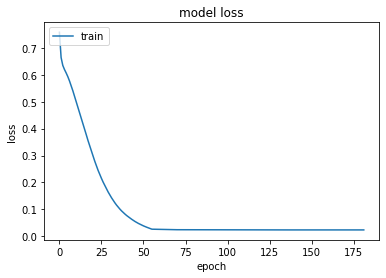

In [18]:
fig = plt.figure()
plt.axes(facecolor='white')
plt.plot(results.history['loss'])
# plt.plot(results.history['accuracy'])
# plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'acc'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.savefig('./210303/residual_filter4_0303.jpg',dpi=300, facecolor='w', edgecolor='w')
plt.show()

In [19]:
test_results= model.predict(img_test, batch_size=128, verbose=1)

324/324 [==============================] - 0s 775us/step


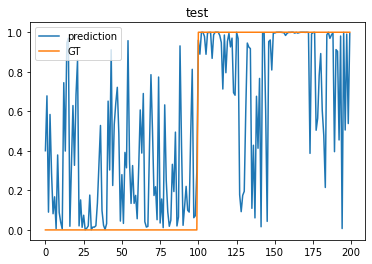

In [16]:
fig = plt.figure()
# plt.axes(facecolor='white')
plt.plot(test_results)
plt.plot(lab_test)
plt.title('test')
plt.legend(['prediction', 'GT'], loc='upper left')
plt.savefig('./result_res_loss_32_169prox400',dpi=200, facecolor='w', edgecolor='w')
plt.show()

In [20]:
score= model.evaluate(img_test, lab_test)
print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))

324/324 [==============================] - 0s 289us/step
loss: 0.20, 정확도: 0.923  


In [18]:
print(test_results)

[[4.0060118e-01]
 [6.7817378e-01]
 [8.9892894e-02]
 [5.8406210e-01]
 [2.8877646e-01]
 [8.1870347e-02]
 [1.6748384e-01]
 [6.3778693e-03]
 [3.7915963e-01]
 [8.8254735e-02]
 [3.8430326e-02]
 [4.6315421e-03]
 [7.4479294e-01]
 [3.9892825e-01]
 [9.4616103e-01]
 [9.7020668e-01]
 [1.8380910e-02]
 [3.2021514e-01]
 [6.2913162e-01]
 [3.2677647e-01]
 [6.8366688e-01]
 [8.5860056e-01]
 [2.0336865e-02]
 [1.5174237e-01]
 [1.3121969e-02]
 [7.4305296e-02]
 [8.9012412e-04]
 [8.2124732e-03]
 [2.0217292e-02]
 [1.7631860e-01]
 [9.1882591e-04]
 [1.4407821e-02]
 [1.3999150e-02]
 [2.1091526e-02]
 [1.3625953e-01]
 [3.3138773e-01]
 [5.2840787e-01]
 [9.7708941e-02]
 [2.3281140e-02]
 [2.2622342e-03]
 [3.1449743e-02]
 [6.5144682e-01]
 [3.0314288e-01]
 [9.1121638e-01]
 [2.2471367e-01]
 [5.3340232e-01]
 [6.4104241e-01]
 [7.2139210e-01]
 [4.8776734e-01]
 [4.4714373e-02]
 [2.7965719e-01]
 [3.2943148e-02]
 [3.9206159e-01]
 [3.1421232e-01]
 [9.5734292e-01]
 [3.4261438e-01]
 [1.3404512e-01]
 [3.2555050e-01]
 [1.3441288e-0

In [22]:
print(len(test_results), len(img_test))

324 324


In [39]:
TN=0
TP=0
FN=0
FP=0
# predicts=[]
for i in range(len(test_results)):
    if i<int(len(test_results)/2):
#         label= 'label: 0'
        if test_results[i]<0.5:
            TN+=1
#             plt.figure()
#             plt.title("num:"+ str(i)+', label: 0, probability:'+str(test_results[i])+ ', predict: 0, normal')
#             plt.imshow(img_test[i,:,:,0],cmap='gray')
#             plt.savefig('./210303/result_img/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
        else:
            FP+=1
#             plt.figure()
#             plt.title("num:"+ str(i)+', label: 0, probability:'+str(test_results[i])+ ', predict: 1, abnormal')
#             plt.imshow(img_test[i,:,:,0],cmap='gray')
#             plt.savefig('./210303/result_img/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
    else:
        label= 'label: 1'
        if test_results[i]<0.5:
            FN+=1
#             plt.figure()
#             plt.title("num:"+ str(i)+', label: 1, probability:'+str(test_results[i])+ ', predict: 0, normal')
#             plt.imshow(img_test[i,:,:,0],cmap='gray')
#             plt.savefig('./210303/result_img/'+str(i),dpi=200, facecolor='w', edgecolor='w')
            
        else:
            TP+=1
#             plt.figure()
#             plt.title("num:"+ str(i)+', label: 1, probability:'+str(test_results[i])+ ', predict: 1, abnormal')
#             plt.imshow(img_test[i,:,:,0],cmap='gray')
#             plt.savefig('./210303/result_img/'+str(i),dpi=200, facecolor='w', edgecolor='w')

In [40]:
print(TP, FP, FN, TN)

155 18 7 144


In [44]:
acc = (TP+TN)/(TP+FP+TN+FN)
prec = TP/(TP+FP)
recall = TP/(TP+FN)
spec = 1-(FP/(TN+FP))

print(acc,prec, recall, spec)

0.9228395061728395 0.8959537572254336 0.9567901234567902 0.8888888888888888


In [26]:
fpr_lr,tpr_lr,_=roc_curve(lab_test,test_results)


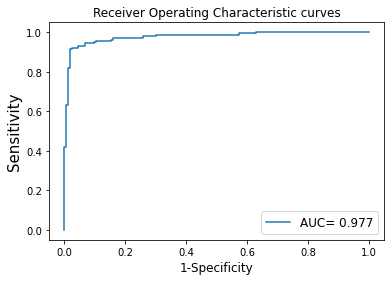

In [27]:
auc_lr=auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label="AUC= %s"%(round(auc_lr,3)))
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('1-Specificity',fontsize=12)
plt.ylabel('Sensitivity',fontsize=15)
plt.title('Receiver Operating Characteristic curves')
plt.legend(loc="lower right",fontsize=12)

plt.savefig('./210303/ROC_residual_filter4_0303.jpg',dpi=300, facecolor='w', edgecolor='w')


In [31]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics._classification:

confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
    Compute confusion matrix to evaluate the accuracy of a classification.
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    labels : array-like of shape (n_classes), default=

In [33]:
predicts=[]
for proba in test_results:
    if proba > 0.5:
        predicts.append(1)
    else:
        predicts.append(0)
print(predicts)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


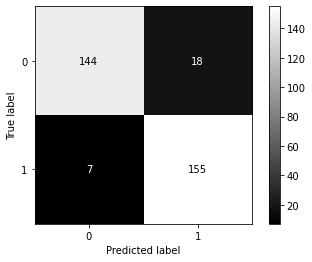

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


confusionMatrix = confusion_matrix(lab_test, predicts)

disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

disp.plot(cmap='gray')
